In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
%matplotlib inline

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#definicao de funcoes que serao utilizadas
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

def score_evasao(y_true, y_pred): 
    tp = confusion_matrix(y_true, y_pred)[0, 0]
    fn = confusion_matrix(y_true, y_pred)[0, 1]
    
    return tp/(tp+fn)
   
#SELECIONANDO MELHOR MODEL RF
def make_RF(Xtrain, ytrain):
    #cria a randomforest 
    #forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 
    forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42) 

    param_grid_forest = {'max_depth': [3, 5, None],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [10, 30, 100, 200],
                  'criterion': ["gini", "entropy"], 
                   #'class_weight': [{0:10, 1:.1}, 'balanced'] #foi utilizado quando os dados estavam desbalanceados
                    }
    
    kappa_scorer = make_scorer(cohen_kappa_score)
    grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = kappa_scorer, cv=10)
    
    grid_search_forest.fit(Xtrain, ytrain)
    print(grid_search_forest.best_params_)
    print(grid_search_forest.best_estimator_)
    
    #mostra os 3 melhores modelos
    report(grid_search_forest.cv_results_, 3)    
    
    return grid_search_forest.best_estimator_

def evaluating(model, ytest, ypred, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print("Cálculo de índices de avaliação:")
    
    print("Precisão: %f; Recall: %f, F1: %f" % (precision_score(ytest, ypred), 
                                                recall_score(ytest, ypred), 
                                                f1_score(ytest, ypred) ))

    #precisao
    print('Precisão CV:')
    scores = cross_val_score(model, Xtest, ytest, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))
    
def feature_ranking(Xtest, model):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show()    

#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

def down_sample(dados):
    # Separate majority and minority classes
    df_majority = dados[dados.classe==1]
    df_minority = dados[dados.classe==0]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0],     # to match minority class
                                     random_state=0) # reproducible results

    # Combine majority class with upsampled minority class
    df_down = pd.concat([df_minority, df_majority_downsampled])

    # Display new class counts
    df_down.classe.value_counts()  
    
    return df_down

def up_sample(dados):
    # separa as classes majoritária e minoritária 
    df_majority = dados[dados.classe==1]
    df_minority = dados[dados.classe==0]

    # Upsample classe minoritária
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample com reposição
                                     n_samples=df_majority.shape[0],    # iguala a quantidade da classe majoritária
                                     random_state=0) 

    # junta as duas classes
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    print(df_upsampled.classe.value_counts()) 
    
    return df_upsampled

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import cohen_kappa_score

import numpy as np

def select_model(Xtrain, Xtest, ytrain, ytest):
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "DecisionTree",
            "estimator": DecisionTreeClassifier(),
            "hyperparameters":
                {
                    "criterion": ["gini", "entropy"],
                    #"min_samples_split": [2],
                    "max_depth": [None, 3, 5],
                    #"min_samples_leaf": [1],
                    "max_leaf_nodes": [None, 5, 10, 20]
                }
        },
        {
            "name": "Naive-Bayes",
            "estimator": GaussianNB(),
            "hyperparameters":
                {
                }
        },
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(n_jobs=-1, random_state=42),
            "hyperparameters":
                {
                    'max_depth': [3, 5, None],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'n_estimators': [10, 30, 100, 200],
                    'criterion': ["gini", "entropy"],                     
                }
        },
        {
            "name":"SVC",
            "estimator":SVC(),
            "hyperparameters":
                {
                  "kernel": ['rbf'],  
                  "C": [0.001, 0.01, 0.1, 1, 10],
                  "gamma": [0.001, 0.01, 0.1, 1]
                }
        },
        {
            # reference
            # https://github.com/UltravioletAnalytics/kaggle-titanic/blob/master/sgdclassifier.py
            "name":"SGDC",
            "estimator": SGDClassifier(),
            "hyperparameters":
            {
                "loss": ["log"],
                "alpha": [0.001],
                "penalty": ["elasticnet"],
                "l1_ratio": [0.8],
                "shuffle": [True],
                "learning_rate": ['optimal'],
                "max_iter":[1000]
            }
        }
    ]      
   
    results = []
    names = []    
     
    #score melhor apropriado para problema de classificação
    kappa_scorer = make_scorer(cohen_kappa_score)
        
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            scoring=kappa_scorer)
        grid.fit(Xtrain, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
        
        #gerar o boxplot
        kfold = model_selection.KFold(n_splits=10, random_state=0)
        cv_results = model_selection.cross_val_score(model["best_model"], Xtest, ytest, cv=kfold, scoring=kappa_scorer)
        model['cv_results'] = cv_results
        results.append(cv_results)
        names.append(model['name'])
        msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot( results )
    ax.set_xticklabels( names )
    plt.xticks(rotation=90)
    plt.show()
        
    return models

In [4]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Cenário 01

para cada algoritmo de ML será testado com todos os dados que não foram gerados de forma artificial e que não foram gerados após o aluno ter entrado no IF (nota, atendimento, frequência).

In [5]:
dados = dados_tunning.copy()

atributos = [
       'aluno_exclusivo_rede_publica', 'artificial', 'classe',
       'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

#down sample
dados = down_sample(dados)

print(dados.classe.value_counts())

1    349
0    349
Name: classe, dtype: int64


In [6]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)    

(698, 22)
(698, 22)
(698, 132)


DecisionTree
------------
Best Score: 0.1738461580424578
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20}
Score do conjunto de testes: 0.182398 (0.220946) 

Naive-Bayes
-----------
Best Score: -0.030567812555814176
Best Parameters: {}
Score do conjunto de testes: -0.036941 (0.158062) 

LogisticRegression
------------------
Best Score: 0.12413296492582299
Best Parameters: {'solver': 'liblinear'}
Score do conjunto de testes: 0.169164 (0.126176) 

KNeighborsClassifier
--------------------
Best Score: 0.17365039491469597
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}
Score do conjunto de testes: 0.190238 (0.168377) 

RandomForestClassifier
----------------------
Best Score: 0.2083271438286436
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
Score do conjunto de testes: 0.164134 (0.155964) 

SVC
---
Best Score: 0.21192138060920324
Best Parameters: {'C': 10, 'gamma'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


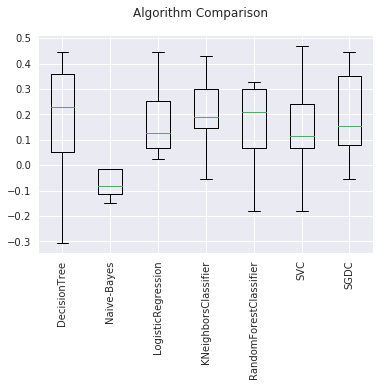

In [37]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

In [38]:
#seleciona os melhores atributos por modelo
for model in res_models:

    if model['name'] in ['Naive-Bayes', 'KNeighborsClassifier', 'SVC']:
        model['best_columns'] = []
        continue
    
    print(model['name'])
    print('-'*len(model['name']))
        
    #seleciona os melhores atributos para cada modelo
    selector = RFECV(model["best_model"], cv=10, n_jobs=-1)
    selector.fit(X, y)

    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n{}\n".format(best_columns))    
    
    #salva os melhores atributos para o modelo
    model['best_columns'] = best_columns   
    
#print(res_models[0]['best_columns'])    
    

DecisionTree
------------
Best Columns 
['idade']

LogisticRegression
------------------
Best Columns 
['aluno_exclusivo_rede_publica', 'idade', 'possui_necessidade_especial', 'tempo_entre_conclusao_ingresso', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Não informado', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pais', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_estado_civil_Divorciado(a)', 'descricao_estado_civil_Não declarado', 'descricao_estado_civil_Solteiro(a)', 'descricao_historico_Técnico de Nivel Médio em Agropecuária, na Forma Integrada', 'descricao_historico_Técnico de Nivel Médio em Biocombustíveis', 'descricao_historico_Técnico de Nivel Médio em Equipamentos Biomédicos', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Agroecologia', 'descricao_historico_Técnico de Nível Médio em Alimentos', 'descricao

KeyboardInterrupt: 

In [54]:
# TESTE

In [7]:
#seleciona o melhor modelo
model_forest_down = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_down.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_down, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_down)

KeyboardInterrupt: 

In [60]:
selector = RFECV(model_forest_down, cv=10, n_jobs=-1)
selector.fit(X, y)

best_columns = list(X.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))

Best Columns 
------------
['aluno_exclusivo_rede_publica', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Pais', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Administração', 'descricao_historico_Técnico de Nível Médio em Alimentos', 'descricao_historico_Técnico de Nível Médio em Apicultura', 'descricao_historico_Técnico de Nível Médio em Edificações', 'descricao_historico_Técnico de Nível Médio em Eventos', 'descricao_historico_Técnico de Nível Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Manutenção e Suporte em Informática', 'descricao_historico_T